# Template for Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

In [339]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

In [340]:
from scipy import signal
import time
import cmath

## Functions

In [341]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [342]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [343]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [344]:
play = False
if play :
    play_sound(sound)

In [345]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [346]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

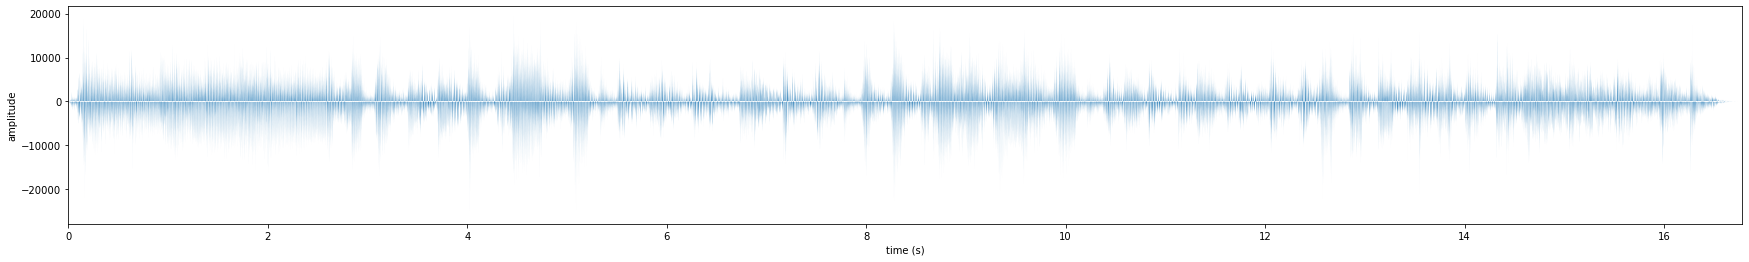

In [347]:
plot_sound(x, times)

# 1 Conversion of sampling rate

## 1.1

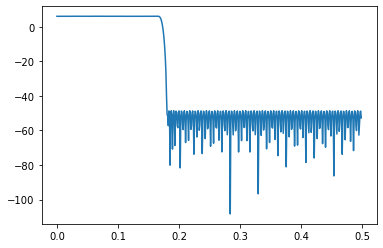

In [348]:
N = 220     # length of filter
nu_c = 1/6  # cutoff frequency
nu_a = 0.18 # beggining frequency of the stopband
L = 2       # band gain

h = signal.remez(N, [0, nu_c, nu_a, .5], [L,0])  # filter synthesis
w, H = signal.freqz(h) # frequency reponse
w_norm = w/(2*np.pi)  # normalized frequency

plt.plot(w_norm,20*np.log10(np.abs(H)))

We actually got the frequency response that we wanted and we can indeed corroborate that there is a difference of more or less 50dB.

## 2

## Digital processing without optimisation

In [349]:
t0= time.time()

#Upsampling
xl = np.zeros(2*len(x))
xl[::2] = x

#Filtering
wo = signal.lfilter(h,1,xl) # w is the signal filtered

#Downsampling
out1 = np.array(len(wo)/3)
out1 = wo[::3]


print("Time of execution:", time.time() - t0)


Time of execution: 0.0948038101196289


## 3

## Digital processing with optimisation

In [350]:
#Definition of the polyphase descomposition

r1 = h[::2]
r0 = h[1::2]

e00 = r0[::3]
e01 = r0[1::3]
e02 = r0[2::3]

e10 = r1[::3]
e11 = r1[1::3]
e12 = r1[2::3]

In [351]:
t = time.time()

#Time shifting
x00 = x[1:]
# x01 = x
x02 = x
x02[1:] = x[:(len(x)-1)] 
x02[0] = 0
# x10 = x
# x11 = x02
x12 = x
x12[0] = 0
x12[1:] = x02[:(len(x)-1)]

#Downsampling
xm = x[::3]
x00m = x00[::3]
x02m = x02[::3]
x12m = x12[::3]

#Filtering
w00 = signal.lfilter(e00,1,x00m) # w is the signal filtered
w01 = signal.lfilter(e01,1,xm)   # w is the signal filtered
w02 = signal.lfilter(e02,1,x02m) # w is the signal filtered
w10 = signal.lfilter(e10,1,xm)   # w is the signal filtered
w11 = signal.lfilter(e11,1,x02m) # w is the signal filtered
w12 = signal.lfilter(e12,1,x12m) # w is the signal filtered

#Sum and then upsampling
w0 = w00 + w01 + w02
w0l = np.zeros(2*len(w0))
w0l[::2] = w0

w1 = w10 + w11 + w12
w1l = np.zeros(2*len(w1))
w1l[::2] = w1


#Time shifting w0l (z^-1)
w0fin = w0l
w0fin[1:] = w0l[:(len(w0l)-1)] 
w0fin[0] = 0

y = w0fin + w1l # output

print("Time of execution: ", time.time() - t)


Time of execution:  0.07612943649291992


In [352]:
write('new_caravan_filtered.wav', int(Fs*(2/3)), np.array(y, dtype=np.int16)) # new wave file of filtered signal
data_path2 = os.getcwd()
filename2 = 'new_caravan_filtered.wav'
sound2 = os.path.join(data_path2, filename2)
wavefile2 = load_sound(sound2)
print(wavefile2.getparams())
play_sound(sound2)

_wave_params(nchannels=1, sampwidth=2, framerate=32000, nframes=537156, comptype='NONE', compname='not compressed')


ALSA lib pcm_dsnoop.c:641:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1089:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
ALSA lib pcm

## 4

We can see that we get different running times for the two implementations used, as expected the efficient implementation has a lower running time of approximately “74.35ms” compared to “114.15ms” from simple digital filter. This is reasonable because the efficient method has a computational cost 36 times less than the simple implementation, having said that I was expecting a bigger difference in times of execution but there are many other factors that affect the times.

# 2 STFT audio equalization

## 2.1 STFT analysis

## 1

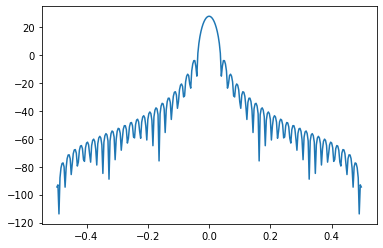

In [353]:
M = 300  #order of the DFT
Nw = 50  #length of the window
w = np.hanning(Nw)  #creation of a hanning window
Wz = np.fft.fft(w,M)  #DFT implementation
Wz = np.fft.fftshift(Wz) #frequency shifting
nu = np.arange(-0.5,0.5,1/M)

plt.plot(nu[1::],20*np.log10(np.abs(Wz))[1::])


We obtained the expected DFT of a hanning window.

## 2

In [354]:
N = x.shape[0] # % Length of signal
Nw = 512
w = np.hanning(Nw) # Definition of the window of analysis
R = Nw/4 # increment on analysis times, called hop size, t_a=uR
M = 512 # DTF order
L = M/2+1   # usefull at the time to plot for avoiding viewing the mirrored
            # Note that an FFT result is mirrored (as in conjugate symmetric) only if the input data is real,
            # which is is our case
affich = 1 ; # 1 for viewing the spectrogram
             # 0 for making the analysis/modifications/synthesis without spectrogram
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # Calculus of quantity the DFT a calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # Signal of synthesis

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

In [355]:
for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # Begining of interval
    fin = deb + Nw # End of interval, intervals always of length Nw
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # x interval multiplied with window "w" interval
    X = np.fft.fft(tx,M) # DFT at the moment b=t_a=u*R
    if affich:
        Xtilde[:,u] = X #matrix of DFT of each interval of time
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

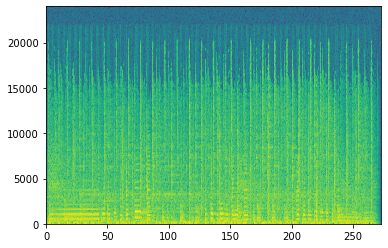

In [356]:
if affich:
    plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0,L).astype(int),:])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])
    

This was the implementation of STFT referred to as "band-pass convention", this is because we are going through all the signal taking different overlapping frames of it, multiplying each frame the hann window and then doing the fft of it.

# 3

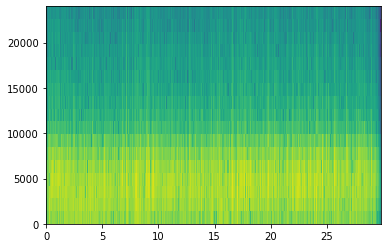

In [357]:
Nw = 26
M = 32 # DTF order

k=3
lambd = k/M
w1 = np.hanning(Nw)
paso = complex(0,2*np.pi*lambd)
k3 = np.arange(0, len(w1), 1 ,dtype=np.complex_)
k3 = k3 * paso
ek3 = np.exp(k3)
filtro = np.multiply(w1,ek3)
w2 = signal.lfilter(filtro,1,x) # w is the signal filtered

N = w2.shape[0] # % Length of signal
R = Nw/Nw # increment on analysis times, called hop size, t_a=uR
L = M/2+1 # usefull at the time to plot for avoiding viewing the mirrored
            #Note that an FFT result is mirrored (as in conjugate symmetric) only if the input data is real. Our case
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # Calculus of quantity the DFT a calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # Begining of interval
    fin = deb + Nw # End of interval, intervals always of length Nw
    tx = np.multiply(w2[np.arange(deb.astype(int),fin.astype(int))],w1) # x interval multiplied with window "w" interval
    X = np.fft.fft(tx,M) # DFT at the moment b=t_a=u*R
    if affich:
        Xtilde[:,u] = X #matrix of DFT of each interval of time
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add


    
if affich:
    plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0,L).astype(int),:])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])

We managed to compute the desired signal, the result obtained is a set of complex values.
The procedure for doing this implementation was taken from the theoric course, it consisted of multiplying our hann window with an exponential set of values, this generates a band-pass filter centred in lambda equals k/M , and then filtering the signal. After that we calculate de spectrogram with the same method as before.

In [358]:
# In here we can listen to the real part of the filtered signal

write('new_caravan_filtered_real.wav', Fs, np.array(np.real(w2), dtype=np.int16)) # to write a new wave file
data_path1 = os.getcwd()
filename1 = 'new_caravan_filtered_real.wav'
sound1 = os.path.join(data_path1, filename1)
wavefile1 = load_sound(sound1)
print(wavefile.getparams())
play_sound(sound1)

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


ALSA lib pcm_dsnoop.c:641:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1089:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
ALSA lib pcm

# 2.1 Overlap-add reconstruction

## 4

In [359]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

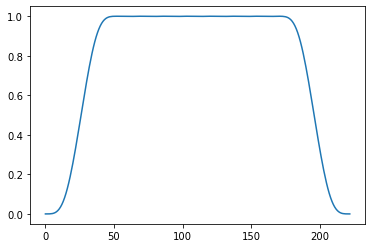

In [360]:
Nw = 70
w = np.hanning(Nw)

wp = w*w # h(n)^2
wp = wp
out = ola(wp, hop=int (Nw/4))
out = out/np.max(out)
plt.plot(out)

## 5

In [361]:
N = x.shape[0] # % Length of signal
Nw = 32
w = np.hanning(Nw) # définition de la fenetre d'analyse
R = Nw/4 # increment on analysis times, called hop size, t_a=uR
M = 32 # DTF order
L = M/2+1 # usefull at the time to plot for avoiding viewing the mirrored
            #Note that an FFT result is mirrored (as in conjugate symmetric) only if the input data is real. Our case
affich = 0 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # Calculus of quantity the DFT a calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # Begining of interval
    fin = deb + Nw # End of interval, intervals always of length Nw
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # x interval multiplied with window "w" interval
    X = np.fft.fft(tx,M) # DFT at the moment b=t_a=u*R
    if affich:
        Xtilde[:,u] = X #matrix of DFT of each interval of time
    # opérations de transformation (sur la partie \nu > 0)
    invfftY = np.fft.ifft(X,Nw) # calculate inverse fft
    ty = np.multiply(np.transpose(invfftY),w) # multiplication
    y[deb.astype(int):fin.astype(int),0] = np.real(y[deb.astype(int):fin.astype(int),0]) + np.real(ty)
    # fin des opérations de transformation
    # resynthèse
    # overlap add


if affich:
    plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0,L).astype(int),:])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])




The implementation of the resynthesis according to the overlap-add approach was done as seen in the code above. Utilising the same windows for analyse and synthesis, and also with hop (R) selected for obtaining 75% overlap, we are in sufficient conditions for perfect reconstruction.

# 2.3 STFT audio equalizer

/tmp/ipykernel_57698/46583565.py:52: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0,L).astype(int),:])), aspect='auto',interpolation='none',


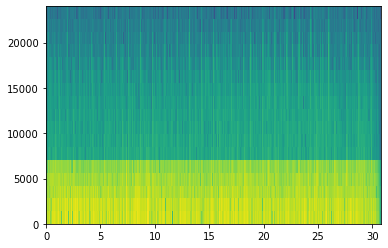

In [362]:
N = x.shape[0] # % Length of signal
Nw = 28
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # Definition of the window synthesis
wk = np.array(M)
R = Nw/4 # increment on analysis times, called hop size, t_a=uR
M = 32 # DTF order


L = M/2+1 # usefull at the time to plot for avoiding viewing the mirrored
            #Note that an FFT result is mirrored (as in conjugate symmetric) only if the input data is real. Our case

# Channels weights set
Ltilde= int(L)

wk = np.full(M,1.0)
wk[0:Ltilde -13] = 1.5
wk[Ltilde-12: Ltilde] = 0.001
wk[Ltilde: Ltilde+12] = 0.001
wk[Ltilde+13:M] = 1.5
    
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # Calculus of quantity the DFT a calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # Begining of interval
    fin = deb + Nw # End of interval, intervals always of length Nw
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # x interval multiplied with window "w" interval
    X = np.fft.fft(tx,M) # DFT at the moment b=t_a=u*R
    Xeq = np.multiply(X,wk)
    if affich:
        Xtilde[:,u] = Xeq #matrix of DFT of each interval of time
    # opérations de transformation (sur la partie \nu > 0)
    invfftY = np.fft.ifft(Xeq,Nw)
    ty = np.multiply(np.transpose(invfftY),w)
    y[deb.astype(int):fin.astype(int),0] = np.real(y[deb.astype(int):fin.astype(int),0]) + np.real(ty)
    
    
    # fin des opérations de transformation
    # resynthèse
    # overlap add


if affich:
    plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0,L).astype(int),:])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])

In [363]:
# In here we can listen to the equalized signal

write('new_caravan_equalizer.wav', Fs, np.array(y[:,0], dtype=np.int16)) # to write a new wave file
data_path = os.getcwd()
filename = 'new_caravan_equalizer.wav'
sound = os.path.join(data_path, filename)
wavefile = load_sound(sound)
print(wavefile.getparams())
play_sound(sound)

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


ALSA lib pcm_dsnoop.c:641:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1089:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
ALSA lib pcm

Equalizer works as expected, if we set the values of channel weights to 1 we obtain the reconstruction equals to the original signal.